# Exoplanets: primary transit

In this example, we show how archNEMESIS can be used to construct input files and calculate forward models useful for exoplanet primary transit observations. Here, we show an example of how to initialise all the classes from scratch, so that users can adapt the notebook according to their own needs. The planet is assumed not to have aerosols, but this can be easily adapted to include these features.

In [1]:
import archnemesis as ans
import numpy as np
import matplotlib.pyplot as plt

## 1. Creating the input files

In [2]:
runname = "exoplanet"

### Defining planet characteristics

In [3]:
# Astronomical constants
AU = 1.495978707e+11      # m astronomical unit
R_SUN = 6.95700e8         # m solar radius
R_JUP = 6.9911e7          # m Jupiter radius
R_JUP_E = 7.1492e7        # m nominal equatorial Jupiter radius
M_SUN = 1.98847542e+30    # kg solar mass
M_JUP = 1.898e27          # kg Jupiter mass
R_EAR_E = 6.3781e6          # m Earth radius
M_EAR = 5.9722e24         # kg Earth mass
G = 6.6743e-11            # m3 kg-1 s-2 Gravitational constant

In [4]:
# L98-59 d
R_star = 0.303 * R_SUN # m M3V star, 80 day rotation period, >0.8 Gyr
M_plt = 1.94 * M_EAR # kg
R_plt = 1.521 * R_EAR_E # m
SMA = 0.0486 * AU # m
T_star = 3415.0 # K
g_plt = G * M_plt / R_plt**2
T_eq = T_star * (R_star/(2*SMA))**0.5
T_int = 200.0 # randomly set

### 1.2. Atmosphere

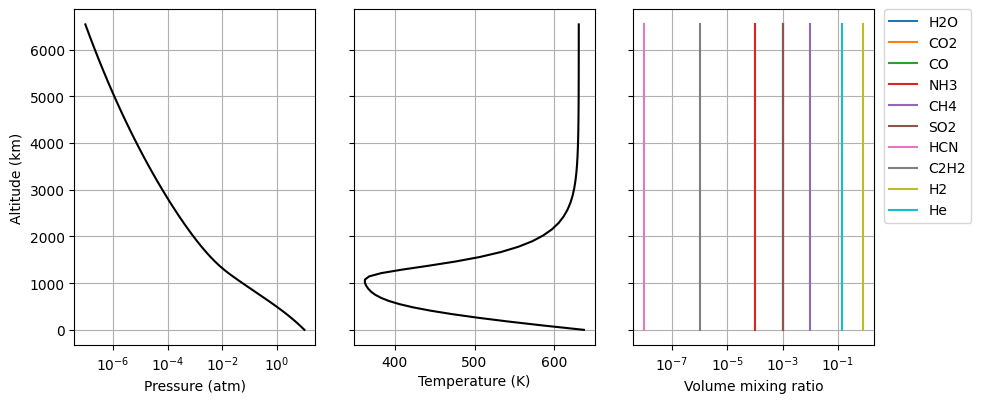

In [5]:
Atmosphere = ans.Atmosphere_0()

Atmosphere.NP = 50   #Number of points in vertical profiles
Atmosphere.LATITUDE = 0. ; Atmosphere.LONGITUDE = 0.
Atmosphere.IPLANET = -1  #Custom planet

#Planetary parameters
Atmosphere.PLANET_MASS = M_plt
Atmosphere.PLANET_RADIUS = R_plt / 1.0e3  #km

#Defining the pressure profile
Atmosphere.edit_P(np.logspace(1, -7, Atmosphere.NP) * 101325.) # in Pa
Atmosphere.edit_H(np.linspace(0.,100.,Atmosphere.NP) * 1.0e3) # dummy height profile (it will be calculated hydrostatically)

#Defining the gaseous abundances
gasID = np.array([1,2,5,11,6, 9,23,26,39,40],dtype='int32') #H2O,CO2,CO,NH3,CH4,SO2,HCN,C2H2,H2(inactive),He(inactive)
isoID = np.zeros(len(gasID),dtype='int32')

abundances_active = np.array([1.0e-3, 1.0e-4, 1.0e-3, 1.0e-4, 1.0e-2, 1.0e-3, 1.0e-8, 1.0e-6])
abundance_inactive = 1. - np.sum(abundances_active)
h2_frac = 0.8547
h2_vmr = abundance_inactive * h2_frac ; he_vmr = abundance_inactive * (1. - h2_frac)
abundances = np.zeros(len(gasID))
abundances[0:len(abundances_active)] = abundances_active
abundances[-2] = h2_vmr
abundances[-1] = he_vmr

Atmosphere.NVMR = len(gasID)
Atmosphere.ID = gasID
Atmosphere.ISO = isoID

vmr = np.zeros((Atmosphere.NP,Atmosphere.NVMR))
vmr[:,:] = abundances[None,:]
Atmosphere.edit_VMR(vmr)
Atmosphere.AMFORM = 2  #Molecular weight calculated internally based on gaseous abundances
Atmosphere.calc_molwt()

#Calculating the temperature profile using the parameterisation of Parmentier and Guillot (2014)
k, g1, g2, alpha, beta = 1.0e-2, 1.0e1, 1.0e1, 0.5, 1.0
Atmosphere, xmap = ans.Models[43].calculate(Atmosphere,alpha,beta,k,g1,g2,T_star,R_star,SMA,T_int)

#Calculating altitudes based on hydrostatic equilibrium equation
Atmosphere.adjust_hydrostatH()

#Calculating the aerosols in the atmosphere (no clouds)
Atmosphere.NDUST = 1
dust = np.zeros((Atmosphere.NP,Atmosphere.NDUST))   #m-3
Atmosphere.edit_DUST(dust)

Atmosphere.assess()
Atmosphere.plot_Atm()
Atmosphere.write_hdf5(runname)

### 1.2. Spectroscopy

In [6]:
#Initialising spectroscopy class with ILBL = 0 (k-tables)
Spectroscopy = ans.Spectroscopy_0(ILBL=0)

Spectroscopy.NGAS = 8  #Number of radiatively active gases
specdir = '/exomars/retrievals/nemesis/spectroscopy/Ktables/Exoplanets/Jake/R1000/'
Spectroscopy.LOCATION = [specdir+'H2O_R1000.kta',
                         specdir+'CO2_R1000.kta',
                         specdir+'CO_R1000.kta',
                         specdir+'NH3_R1000.kta',
                         specdir+'CH4_R1000.kta',
                         specdir+'SO2_R1000.kta',
                         specdir+'HCN_R1000.kta',
                         specdir+'C2H2_R1000.kta']

#Reading the header information
Spectroscopy.read_header()

#Printing summary information
Spectroscopy.summary_info()
Spectroscopy.write_hdf5(runname)

INFO :: summary_info :: Spectroscopy_0.py-233 :: Calculation type ILBL ::  (<SpectralCalculationMode.K_TABLES: 0>, ' (k-distribution)')
INFO :: summary_info :: Spectroscopy_0.py-234 :: Number of radiatively-active gaseous species ::  8
INFO :: summary_info :: Spectroscopy_0.py-241 :: Gaseous species ::  ['H2O', 'CO2', 'CO', 'NH3', 'CH4', 'SO2', 'HCN', 'H2O']
INFO :: summary_info :: Spectroscopy_0.py-243 :: Number of g-ordinates ::  20
INFO :: summary_info :: Spectroscopy_0.py-245 :: Number of spectral points ::  5119
INFO :: summary_info :: Spectroscopy_0.py-246 :: Wavelength range ::  (0.3001500070095062, '-', 49.997337341308594)
INFO :: summary_info :: Spectroscopy_0.py-247 :: Step size ::  0.0003001391887664795
INFO :: summary_info :: Spectroscopy_0.py-249 :: Spectral resolution of the k-tables (FWHM) ::  0.0
INFO :: summary_info :: Spectroscopy_0.py-251 :: Number of temperature levels ::  27
INFO :: summary_info :: Spectroscopy_0.py-252 :: Temperature range ::  (100.0, '-', 3400.0)

### 1.3. Measurement

In [7]:
#Initialising the class
Measurement = ans.Measurement_0()

Measurement.ISPACE = 1  #Wavelength (um)
Measurement.NGEOM = 1   #Number of geometries (just one spectrum)
Measurement.FWHM = 0.0  #Assuming no instrumental broadening
Measurement.IFORM = 2   #Transit depth (Area_planet/Area_star*100)

#Defining the spectral range
vmin = 0.5 ; vmax = 35.
vconvx = Spectroscopy.WAVE[ (Spectroscopy.WAVE>=vmin) & (Spectroscopy.WAVE<=vmax) ]
nconvx = len(vconvx)

vconv = np.zeros((nconvx,Measurement.NGEOM))
vconv[:,0] = vconvx

Measurement.NCONV = np.zeros(Measurement.NGEOM,dtype='int32') + nconvx
Measurement.edit_VCONV(vconv)
Measurement.edit_MEAS(np.ones(vconv.shape))     #Dummy arrays for the measured spectrum since we are only simulating
Measurement.edit_ERRMEAS(np.ones(vconv.shape))  

#Initialising the arrays with the geometry (not important for primary transits since it is accounted for in the forward model)
Measurement.calc_geometry_primary_transit()

#Checking that everything is consistent
Measurement.summary_info()

#Writing file
Measurement.write_hdf5(runname)

INFO :: summary_info :: Measurement_0.py-422 :: Spectral resolution of the measurement is account for in the k-tables
INFO :: summary_info :: Measurement_0.py-432 :: Field-of-view centered at ::  ('Latitude', 0.0, '- Longitude', 0.0)
INFO :: summary_info :: Measurement_0.py-433 :: There are  (1, 'geometries in the measurement vector')
INFO :: summary_info :: Measurement_0.py-435 :: 
INFO :: summary_info :: Measurement_0.py-436 :: GEOMETRY 1
INFO :: summary_info :: Measurement_0.py-437 :: Minimum wavelength/wavenumber :: 0.5002095103263855 um/19991.623097039927 cm^-1 - Maximum wavelength/wavenumber :: 34.993003845214844 um/285.77140860022115 cm^-1
INFO :: summary_info :: Measurement_0.py-466 :: Limb-viewing or solar occultation measurement. Latitude ::  (0.0, ' - Longitude :: ', 0.0, ' - Tangent height :: ', 0.0)


### 1.4. Surface

In [8]:
#Initialising and creating dummy surface class
Surface = ans.Surface_0()
Surface.GASGIANT = True   #No surface
Surface.TSURF = 0.0
Surface.GALB = 0.0
Surface.LOWBC = 0
Surface.assess()
Surface.write_hdf5(runname)

### 1.5. Scatter

In [9]:
Scatter = ans.Scatter_0()
Scatter.ISCAT = 0   #No scattering

#Now we initialise the arrays, but they won't be used since there are no aerosols in the atmosphere
Scatter.initialise_arrays(NDUST=1,NWAVE=2,NTHETA=5)
Scatter.WAVE = np.linspace(Spectroscopy.WAVE.min(),Spectroscopy.WAVE.max(),Scatter.NWAVE)
Scatter.assess()
Scatter.write_hdf5(runname)

### 1.6. CIA

In [10]:
#Initialising the CIA class
CIA = ans.CIA_0()

#Indicating the name of the CIA file
CIA.CIATABLE = "exocia_hitran12_200-3800K.h5"

#Writing information to file
CIA.assess()
CIA.write_hdf5(runname)

### 1.7. Stellar spectrum

In [11]:
#Initialising class
Stellar = ans.Stellar_0()

#Defining the planet-star distance
Stellar.DIST = SMA / AU   #Star-Planet distance (AU)

#Writing the information into HDF5 file
Stellar.write_hdf5(runname,solfile='solar_noaa_wl_2024.txt')

### 1.8. Layering

In [12]:
#Initialising class
Layer = ans.Layer_0()

Layer.NLAY =  31     #Number of atmospheric layers
Layer.LAYHT = 0.0    #Altitude of lowest layer in atmosphere
Layer.LAYINT = 1     #Curtis-Godson layer integration
Layer.LAYTYP = 1     #Layers divided by equal changes in log(pressure)

Layer.write_hdf5(runname)

### 1.9. Retrieval

In [13]:
Retrieval = ans.OptimalEstimation_0(IRET=0)

Retrieval.NITER = -1       #Number of iterations
Retrieval.PHILIMIT = 0.1   #Convergence criterion
Retrieval.NCORES = 1       #Number of available cores

Retrieval.assess_input()
Retrieval.write_input_hdf5(runname)

### 1.10. Variables

In [14]:
#Retrieving a scaling factor for the CO2 abundance
f = open(runname+".apr","w")

NVAR = 1

f.write("#Exoplanet example \n")
f.write(str(NVAR)+" \n")
f.write("2 0 2 \n")
f.write("1.0 0.5 \n")
f.close()

## 2. Running forward model

In [15]:
#Reading the input files
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval,Telluric = ans.Files.read_input_files_hdf5(runname)

INFO :: read_apr :: Variables_0.py-823 :: 
Variables_0 :: read_apr :: varident [2 0 2]. Constructed model "Model2" (id=2)
INFO :: read_apr :: Variables_0.py-826 ::   Model2:
  |- id : 2
  |- parent classes: PreRTModelBase
  |- description: In this model, the atmospheric parameters are scaled using a
  |               single factor with  respect to the vertical profiles in the
  |               reference atmosphere
  |- n_state_vector_entries : 1
  |- state_vector_slice : slice(0, 1, None)
  |- state_vector_start : 0
  |- target : 0
  |- Parameters:
  |  |- scaling_factor :
  |  |  |- slice : slice(0, 1, None)
  |  |  |- unit : PROFILE_TYPE
  |  |  |- description: Scaling factor applied to the reference profile
  |  |  |- apriori value : 1.0


In [16]:
ForwardModel = ans.ForwardModel_0(Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables,Telluric=Telluric)

SPECONV = ForwardModel.nemesisPTfm()

INFO :: __init__ :: ForwardModel_0.py-256 :: Checking atmospheric gasses have spectroscopy data.
# WARNING #########################################################################

The following atmospheric gasses ARE NOT PRESENT in the spectroscopy data and WILL NOT CONTRIBUTE TO OPACITY:

    C2H2 (id 26) isotopologue 0
    H2 (id 39) isotopologue 0
    He (id 40) isotopologue 0

To deactivate this warning place a path to a k-table file for these gasses in one of the following locations (depending upon your input file type):

    [HDF5 Input]
        In the "wasp121.h5" file, add an entry to "/Spectroscopy/LOCATION"
        and update "/Spectroscopy/NGAS" appropriately.

    [LEGACY Input]
        Add an entry to the "wasp121.kls" file.

# END WARNING #####################################################################
INFO :: nemesisPTfm :: ForwardModel_0.py-1809 :: Calculating forward model for primary transit observation
INFO :: nemesisPTfm :: ForwardModel_0.py-1837 :: Running C

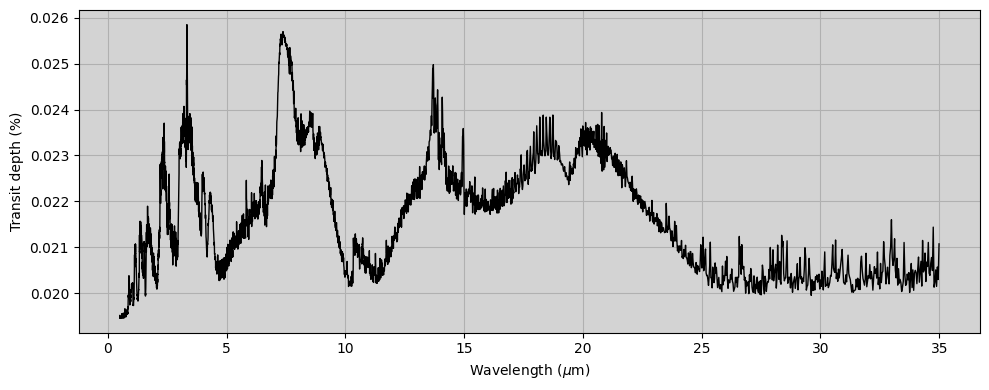

In [17]:
fig,ax1 = plt.subplots(1,1,figsize=(10,4))

ax1.plot(Measurement.VCONV[:,0],SPECONV,c='black',linewidth=1.)
ax1.grid()
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('Transit depth (%)')
ax1.set_facecolor('lightgray')
plt.tight_layout()


## 3. Calculating Jacobian matrix

In this example we show how we can calculate the Jacobian matrix as for any other forward model type using the functionality of the ForwardModel class. Here, since we have indicated that the parameter in the state vector is a scaling factor for the CO$_2$ abundance, the Jacobian matrix will only have one element, showing the sensitivity to the CO$_2$ abundance. The Jacobian matrix for any other models can be calculated just by specifying the information in the .apr file.

In [18]:
ForwardModel = ans.ForwardModel_0(Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables,Telluric=Telluric)

YN,KK = ForwardModel.jacobian_nemesis(nemesisPT=True)

INFO :: jacobian_nemesis :: ForwardModel_0.py-2191 :: Calculating analytical part of the Jacobian :: Calling nemesisfmg 
INFO :: nemesisPTfm :: ForwardModel_0.py-1809 :: Calculating forward model for primary transit observation
INFO :: nemesisPTfm :: ForwardModel_0.py-1840 :: Running CIRSradg for primary transit observation
INFO :: calculate_vertical_cia_opacity :: ForwardModel_0.py-3765 :: Calculating self.CIAX opacity
INFO :: calculate_layer_opacity :: ForwardModel_0.py-3834 :: CIRSrad :: Aerosol optical depths at  (0.5002095103263855, ' :: ', array([0.]))
INFO :: calculate_layer_opacity :: ForwardModel_0.py-3852 :: Calculating TOTAL opacity
INFO :: calculate_layer_opacity :: ForwardModel_0.py-3869 :: CIRSradg :: Calculating TOTAL line-of-sight opacity
INFO :: CIRSrad :: ForwardModel_0.py-4201 :: CIRSrad :: IMODM = <PathCalc.PLANCK_FUNCTION_AT_BIN_CENTRE: 8192>
INFO :: nemesisPTfm :: ForwardModel_0.py-1844 :: Mapping gradients from Layer to Profile
INFO :: nemesisPTfm :: ForwardModel

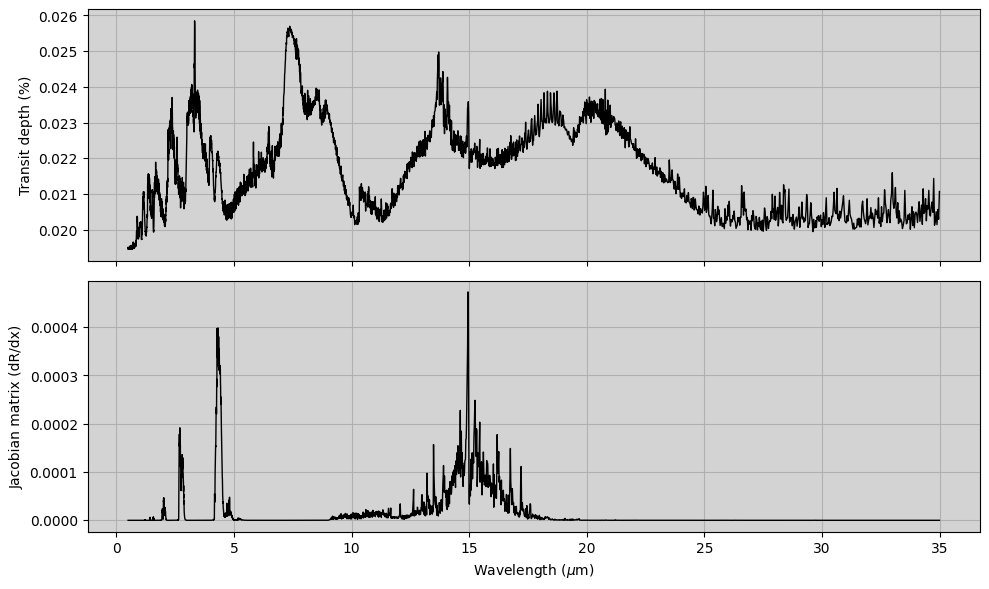

In [19]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,6),sharex=True)

ax1.plot(Measurement.VCONV[:,0],YN,c='black',linewidth=1.)
ax1.grid()
ax2.plot(Measurement.VCONV[:,0],KK,c='black',linewidth=1.)
ax2.grid()
ax2.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('Transit depth (%)')
ax2.set_ylabel('Jacobian matrix (dR/dx)')
ax1.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')
plt.tight_layout()